In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

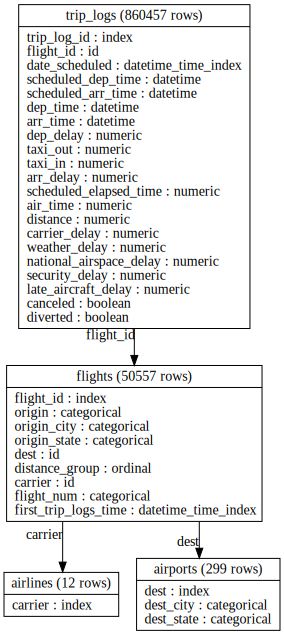

In [2]:
es = ft.demo.load_flight()
es.plot()

In [3]:
def flight_delay(df):
    value = df.arr_time.sub(df.scheduled_arr_time)
    value = value.abs().mean()
    return value

In [4]:
lm = cp.LabelMaker(
    target_entity='flight_id',
    labeling_function=flight_delay,
    time_index='date_scheduled',
    window_size='1w',
)

In [5]:
lt = lm.search(
    es['trip_logs'].df,
    num_examples_per_instance=3,
    minimum_data='2016-10',
    verbose=True,
)

Elapsed: 02:54 | Remaining: 00:00 | Progress: 100%|██████████| flight_id: 151671/151671 


In [6]:
labels = ['<= 10 mins', '10 - 20 mins', '> 20 mins']

bins = [
    lt.flight_delay.min(),
    pd.Timedelta('10min'),
    pd.Timedelta('20min'),
    lt.flight_delay.max(),
]

bins

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:10:00'),
 Timedelta('0 days 00:20:00'),
 Timedelta('0 days 22:12:00')]

In [7]:
lt_bin = lt.bin(bins=bins, labels=labels)

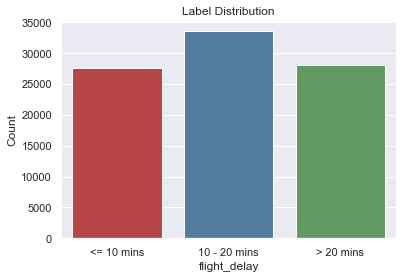

In [8]:
lt_bin.plot.dist();

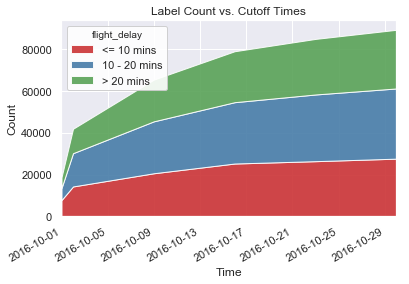

In [9]:
lt_bin.plot.count_by_time();

In [10]:
n = [1000] * len(labels)
n = dict(zip(labels, n))
n

{'<= 10 mins': 1000, '10 - 20 mins': 1000, '> 20 mins': 1000}

In [11]:
cutoff_time = lt_bin.sample(n=n, random_state=0)

In [12]:
cutoff_time.describe()

Label Distribution
------------------
10 - 20 mins    1000
<= 10 mins      1000
> 20 mins       1000
Total:          3000


Settings
--------
gap                                       None
label_type                            discrete
labeling_function                 flight_delay
minimum_data                           2016-10
num_examples_per_instance                    3
target_entity                        flight_id
window_size                  <Week: weekday=6>


Transforms
----------
1. bin
  - bins:         [0 days 00:00:00, 0 days 00:10:00, 0 days 00:2...
  - labels:                   [<= 10 mins, 10 - 20 mins, > 20 mins]
  - quantiles:                                                False
  - right:                                                     True

2. sample
  - frac:                                                         None
  - n:               {'<= 10 mins': 1000, '10 - 20 mins': 1000, '> ...
  - random_state:                                                    0
  

In [13]:
fm, fd = ft.dfs(
    target_entity='flights',
    entityset=es,
    cutoff_time=cutoff_time,
    agg_primitives=['sum', 'max', 'mean', 'min'],
    trans_primitives=['hour', 'weekday'],
    verbose=True,
)

Built 155 features
Elapsed: 00:10 | Progress: 100%|██████████


In [14]:
y = fm.pop(cutoff_time.name)

In [15]:
x = fm.fillna(0)
x, fe = ft.encode_features(x, fd)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

In [17]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

10 - 20 mins       0.39      0.37      0.38       187
  <= 10 mins       0.52      0.35      0.42       237
   > 20 mins       0.39      0.57      0.46       176

    accuracy                           0.42       600
   macro avg       0.43      0.43      0.42       600
weighted avg       0.44      0.42      0.42       600



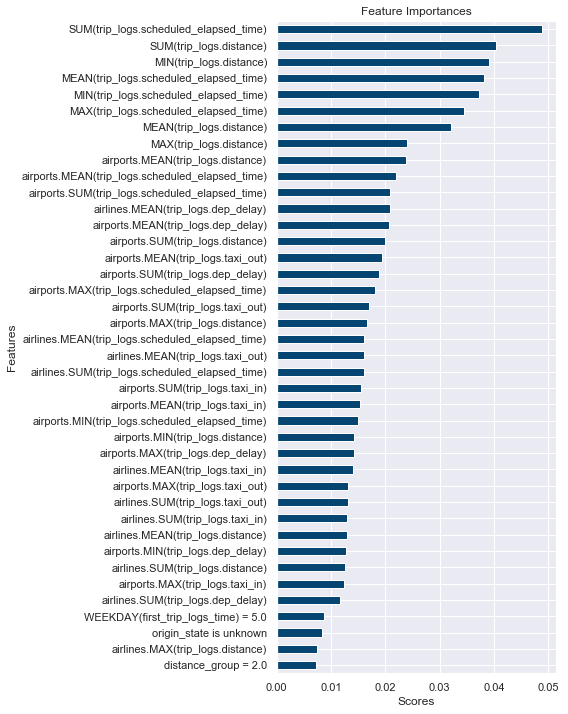

In [19]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');